In [1]:
# Start loading libraries

#! pip install yfinance

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

#! pip install pmdarima
import pmdarima as pm
from pmdarima import model_selection
from pmdarima.model_selection import SlidingWindowForecastCV

import scipy
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from arch.unitroot import PhillipsPerron
from arch.unitroot import KPSS

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA
#from statsmodels.graphics.tsaplots import plot_acf

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

from scipy.optimize import minimize
from random import gauss
import math
from statistics import mean, stdev

from numpy import asarray
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot

#from matplotlib.ticker import NullFormatter
#import yfinance as yf
#import warnings; warnings.simplefilter('ignore')
#%matplotlib inline

In [2]:
xls_file = pd.ExcelFile("Data_monthly_final.xlsx") # Read Excel
df1=xls_file.parse("Gasoil") # Read the first sheet (Portfolio holdings)

#df1["Timestamp"] = df1["Date"].astype('datetime64[ns]') # Convert column to date format
df1 = df1.set_index(['Timestamp']) # use first column as index

#df1.to_excel("values.xlsx")  #print to excel



In [3]:
spot = df1["LGOc1"]
spot = np.log(spot)
spot = spot.loc['2004-01-31':'2022-11-30']
spot_train = spot.loc[:'2016-07-31']
#spot_train.plot()

In [4]:
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
 #n_vars = 1 if type(data) is list else data.shape[1]
 df_temp = pd.DataFrame(data)
 cols = list()
 # input sequence (t-n, ... t-1)
 for i in range(n_in, 0, -1):
    cols.append(df_temp.shift(i))
 # forecast sequence (t, t+1, ... t+n)
 for i in range(0, n_out):
    cols.append(df_temp.shift(-i))
 # put it all together
 agg = pd.concat(cols, axis=1)
 # drop rows with NaN values
 if dropnan:
    agg.dropna(inplace=True)
 return agg.values

In [5]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]

In [6]:
# Load the data and split it into separate pieces
data = np.array(spot.dropna())
train, test = model_selection.train_test_split(data, train_size=(spot_train.shape[0]))

time_lag = 12

data_new = series_to_supervised(data, n_in=time_lag, n_out=1, dropnan=True)
#train, test = model_selection.train_test_split(data, train_size=(spot.shape[0]-1))

In [7]:
#train_new  = series_to_supervised(train, n_in=time_lag, n_out=1, dropnan=True)
#test_new = series_to_supervised(test, n_in=time_lag, n_out=1, dropnan=True)

In [8]:
# fit an random forest model and make a one step prediction
def random_forest_forecast(train, testX):
 # transform list into array
 train = asarray(train)
 # split into input and output columns
 trainX, trainy = train[:, :-1], train[:, -1]
 # fit model
 model = RandomForestRegressor(n_estimators=1000)
 #model = RandomForestRegressor(n_estimators=100, max_features=0.3)
 model.fit(trainX, trainy)
 # make a one-step prediction
 yhat = model.predict([testX])
 return yhat[0]

In [9]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
   predictions = list()
   # split dataset
   train1, test1 = train_test_split(data, n_test)
   # seed history with training dataset
   history = [x for x in train1]
   # step over each time-step in the test set
   for i in range(len(test1)):
      # split test row into input and output columns
      testX, testy = test1[i, :-1], test1[i, -1]
      # fit model on history and make a prediction
      yhat = random_forest_forecast(history, testX)
      # store forecast in list of predictions
      predictions.append(yhat)
      # add actual observation to history for the next loop and delete oldest one
      history.append(test1[i])
      history.pop(0)
      # summarize progress
      print('>expected=%.1f, predicted=%.1f' % (testy, yhat))

    # estimate prediction error
   error = mean_absolute_error(test1[:, -1], predictions)
   return error, test1[:, -1], predictions 

  

>expected=6.0, predicted=6.0
>expected=6.1, predicted=6.1
>expected=6.1, predicted=6.1
>expected=6.1, predicted=6.1
>expected=6.2, predicted=6.1
>expected=6.2, predicted=6.3
>expected=6.2, predicted=6.3
>expected=6.2, predicted=6.3
>expected=6.1, predicted=6.1
>expected=6.1, predicted=6.1
>expected=6.1, predicted=6.1
>expected=6.2, predicted=6.1
>expected=6.2, predicted=6.2
>expected=6.3, predicted=6.2
>expected=6.3, predicted=6.3
>expected=6.3, predicted=6.3
>expected=6.4, predicted=6.3
>expected=6.4, predicted=6.4
>expected=6.4, predicted=6.4
>expected=6.4, predicted=6.4
>expected=6.5, predicted=6.4
>expected=6.5, predicted=6.5
>expected=6.5, predicted=6.6
>expected=6.5, predicted=6.6
>expected=6.5, predicted=6.5
>expected=6.6, predicted=6.6
>expected=6.6, predicted=6.6
>expected=6.3, predicted=6.6
>expected=6.2, predicted=6.4
>expected=6.4, predicted=6.2
>expected=6.4, predicted=6.4
>expected=6.4, predicted=6.4
>expected=6.5, predicted=6.4
>expected=6.4, predicted=6.4
>expected=6.4,

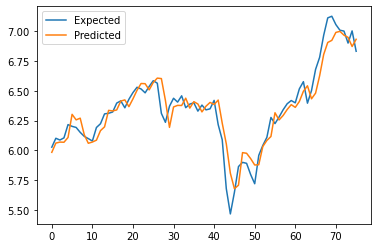

In [10]:
# evaluate
mae, y, yhat = walk_forward_validation(data_new, len(test))
print('MAE: %.3f' % mae)
# plot expected vs predicted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()

In [11]:
def smape_kun(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true) / ((np.abs(y_pred) + np.abs(y_true))/2))*100

In [12]:
predictions = yhat

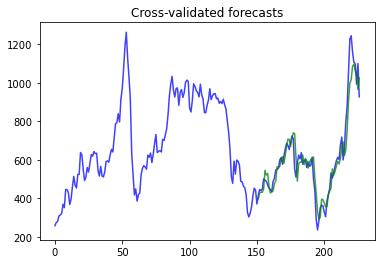

In [13]:
exp_predictions = np.exp(predictions)
exp_spot= np.exp(spot)
exp_test = np.exp(test)
exp_train = np.exp(train)

x_axis = np.arange(exp_spot.shape[0])
n_test = exp_predictions.shape[0]

plt.plot(x_axis, exp_spot, alpha=0.75, c='b')
plt.plot(x_axis[-n_test:], exp_predictions, alpha=0.75, c='g')  # Forecasts
plt.title("Cross-validated forecasts")
plt.show()

In [14]:
error = mean_squared_error(exp_test, exp_predictions)
print('Mean Squared Error: %.3f' % error)
error2 = mean_absolute_error(exp_test, exp_predictions)
print('Mean Absolute Error: %.3f' % error2)
error3 = mean_absolute_percentage_error(exp_test, exp_predictions)
print('Mean Absolute Percentage Error: %.3f' % (error3*100))
error4 = smape_kun(exp_test, exp_predictions)
print('Symmetric Mean Absolute Percentage Error: %.3f' % error4)

Mean Squared Error: 5030.993
Mean Absolute Error: 51.478
Mean Absolute Percentage Error: 8.795
Symmetric Mean Absolute Percentage Error: 8.589


In [15]:
### same with built-in function ###

#predictions22 = model_selection.cross_val_score(
#    ar, spot, scoring='mean_absolute_error', cv=cv, verbose=0)
#np.average(predictions22)

In [16]:
#### MASE ###

abs_errors = abs(exp_predictions - exp_test)
mae_naive_list = []

for x in range(len(exp_test)):
    insample_data = exp_spot[x:-(len(exp_test)-x)]
    mae_insample = np.mean(abs(insample_data.diff().dropna()))
    mae_naive_list.append(mae_insample)

mase = np.mean(abs_errors / mae_naive_list)

print('Mean Absolute Scaled Error: %.3f' % mase)

Mean Absolute Scaled Error: 1.212


In [17]:
### Returns ###

returns = []

test_app2 = list(exp_test)
test_app2.insert(0, exp_train[-1]) ## append last of train data
price_moves = np.array(pd.DataFrame(test_app2).pct_change().dropna()+1)

pred_app2 = list(predictions)

test_shift2 = list(test)
test_shift2.insert(0, train[-1])
test_shift2.pop()

dir_pred2 = np.array(np.sign([a - b for a, b in zip(pred_app2,test_shift2)]))

for t in range(len(dir_pred2)):
    if dir_pred2[t] == 1:
            returns.append(price_moves[t])
        
    if dir_pred2[t] == -1:
        returns.append(1/price_moves[t])

returns = pd.DataFrame(returns)
returns


,0
0,1.116498
1,1.077805
2,1.014764
3,0.982153
4,1.117680
...,...
71,1.048351
72,1.007283
73,1.105965
74,0.902749


In [18]:
### Returns t-test ###

t_statistic, p_value = stats.ttest_1samp(a=returns, popmean=1, alternative='greater') ### one tailed test?


print(t_statistic , p_value)

[1.88111643] [0.03191869]


In [19]:
### Merton test ###

test_app = list(test)
test_app.insert(0, train[-1]) ## append last of train data
dir = np.array(np.sign(pd.DataFrame(test_app).diff().dropna()))

pred_app = list(predictions)

test_shift = list(test)
test_shift.insert(0, train[-1])
test_shift.pop()

dir_pred = np.array(np.sign([a - b for a, b in zip(pred_app,test_shift)]))

q_minus = 0
q_plus = 0
pred_minus = 0
pred_plus = 0

for t in range(len(dir)):
    if dir[t] == 1:
        q_plus += 1
        if dir_pred[t] == 1:
            pred_plus += 1
    if dir[t] == -1:
        q_minus += 1
        if dir_pred[t] == -1:
            pred_minus += 1

print('Merton test: %.3f' % ((pred_plus / q_plus) + (pred_minus / q_minus)))

Merton test: 1.159
